In [1]:
! pip install qutip qutip-qip

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.3/16.3 MB 30.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.6/128.6 kB 15.3 MB/s eta 0:00:00


In [2]:
import qutip
import qutip_qip
import matplotlib.pyplot as plt
import numpy as np

/usr/local/lib/python3.10/dist-packages/qutip/__init__.py:65: UserWarning: The new version of Cython, (>= 3.0.0) is not supported.
  warnings.warn(


# Simulating the dynamics of a single Transmon

Transmon qubit is one of the most well-known types of qubits. In this hands-on example, we will model the Transmon qubit as a three-level system and study its dynamic. In particular, because of the presence of the second excited level, the population may leak out of the qubit subspace, leading to the degradation of fidelity. We will study how this leakage error can be suppressed by pulse shaping (DRAG pulse) and use `qutip-qip` to study its calibration.

## Transmon qubit - weakly anharmonic oscillator
The Hamiltonian of an idling Transmon in the rotating frame can be written as

$
H_0 = w_0 a^{\dagger}a + \frac{\alpha}{2}a^{\dagger}a^{\dagger}aa
$

The resonant control Hamitonian that drives the transition is given by

$
H_c = \Omega_z a^{\dagger}a + \Omega_x(a+a^{\dagger}) + \Omega_y i( a^{\dagger}-a)
$

In [3]:
# Define the operators
a = qutip.destroy(3)
alpha = -2 * np.pi * 0.3  # GHz
# Hamiltonian in the rotating frame
H0 = alpha/2 * a.dag() * a.dag() * a * a
Hx = a + a.dag()
Hy = - 1.j * a + 1.j * a.dag()
Hz = a.dag() * a

### Implementing an X gate

Typically a drive pulse looks like this.

Text(0, 0.5, '$\\Omega_H$ [MHz]')

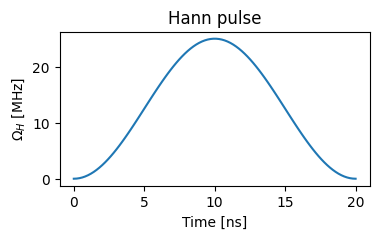

In [4]:
# Define a Hann pulse shape
T = 20 # ns
tlist = np.linspace(0, T, 100)
Omega_0 = 2 * np.pi * 1 / T  # GHz
hann_window = np.sin(np.pi*tlist/T)**2
pulse = Omega_0 / 2 * hann_window

fig, ax = plt.subplots(figsize=(4, 2))
ax.plot(tlist, pulse / 2 / np.pi * 1000)
ax.set_title("Hann pulse")
ax.set_xlabel("Time [ns]")
ax.set_ylabel(r"$\Omega_H$ [MHz]")

We can compute the unitary evolution and the gate fidelity using `qutip`.

In [5]:
H_hann = [H0, [Hx, pulse]]
# propagator computes the full unitary
U = qutip.propagator(H_hann, t=tlist)[-1]
print("Leakage transition probability 0-2:", np.abs(U[0,2])**2)
print("Leakage transition probability 1-2:", np.abs(U[1,2])**2)
print("X gate fidelity:", qutip.average_gate_fidelity(qutip.Qobj(U.full()[:2,:2]), qutip.sigmax()))

Leakage transition probability 0-2: 2.835160362380211e-06
Leakage transition probability 1-2: 2.9722290058282595e-06
X gate fidelity: 0.9965186435315171


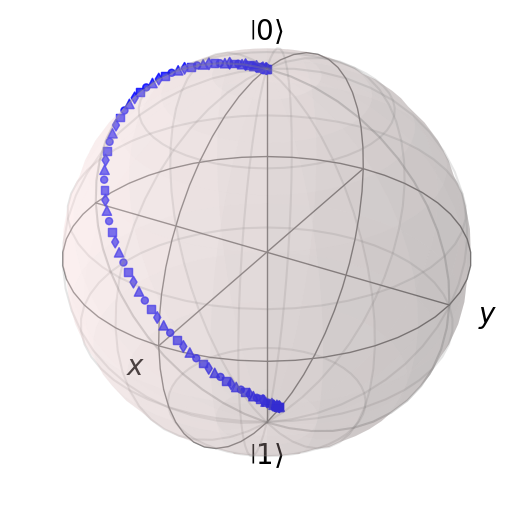

In [6]:
results = qutip.sesolve(H_hann, qutip.basis(3,0), tlist=tlist)
truncated_results = results

bloch = qutip.Bloch()
bloch.point_color = ["b"]
bloch.add_states([qutip.Qobj(state[:2]) for state in results.states], alpha=0.5, kind= 'point')
bloch.show()

One can see that the trajectory deviates from state 1.



### DRAG (Derivative Removal by Adiabatic Gate) pulse
The DRAG pulse shape is often used to suppress the leakage error. To the third order perturbative approximation, it can be written as:

- $\Omega_x = \Omega - \frac{\Omega^3}{\alpha^2}$
- $\Omega_y = - \frac{\dot{\Omega}}{\alpha}$
- $\Omega_z = -  \frac{2\Omega^2}{\alpha}$

Experimentally the detuning $\Omega_z$ is often replaced by a constant and needs to be calibrated separately. Here we use this analytical time-dependent solution for simplicity.

In [7]:
deriv_pulse = np.gradient(pulse, tlist[1] - tlist[0]) # Compute the derivative
x_pulse = pulse - (pulse**3 / (alpha**2))
y_pulse = - deriv_pulse / alpha
z_pulse = - 2 * (pulse**2) / alpha

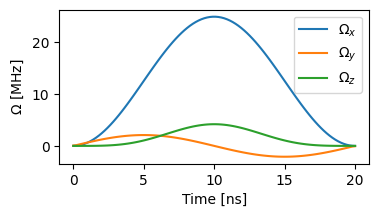

In [8]:
fig, ax = plt.subplots(figsize=(4, 2))
ax.plot(tlist, x_pulse / 2 / np.pi * 1000, label=r"$\Omega_x$")
ax.plot(tlist, y_pulse / 2 / np.pi * 1000, label=r"$\Omega_y$")
ax.plot(tlist, z_pulse / 2 / np.pi * 1000, label=r"$\Omega_z$")
ax.legend()
ax.set_xlabel("Time [ns]")
ax.set_ylabel(r"$\Omega$ [MHz]");

In [9]:
H_drag = [H0, [Hx, x_pulse], [Hy, y_pulse], [Hz, z_pulse]]
U = qutip.propagator(H_drag, t=tlist)[-1]
print("Leakage transition probability 0-2:", np.abs(U[0,2])**2)
print("Leakage transition probability 1-2:", np.abs(U[1,2])**2)
print("X gate fidelity:", qutip.average_gate_fidelity(qutip.Qobj(U.full()[:2,:2]), qutip.sigmax()))

Leakage transition probability 0-2: 2.3042278901343928e-09
Leakage transition probability 1-2: 2.3099385555889934e-09
X gate fidelity: 0.9999999028464167


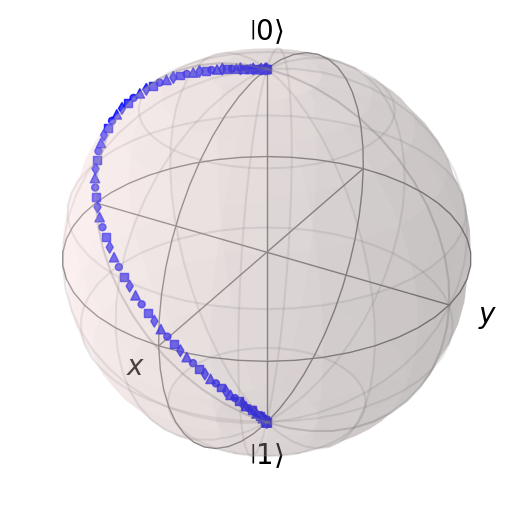

In [10]:
results = qutip.sesolve(H_drag, qutip.basis(3,0), tlist=tlist)
truncated_results = results

bloch = qutip.Bloch()
bloch.point_color = ["b"]
bloch.add_states([qutip.Qobj(state[:2]) for state in results.states], alpha=0.5, kind= 'point')
bloch.show()

## Calibration of the DRAG strength

In the first part, we studied the dynamics of DRAG pulse and achieved very high fidelity. However, in experiment we usually don't know the model well enough and there might also be other effect that changes the dynamics (higher levels, deviation from the standard Duffing model, parastic qubit-qubit interaction etc.). Hence, the Y and Z part of the DRAG pulse is often calibrated by optimizing the drive amplitude $\Omega_{y/z}$.

In the following, we use the feature of `qutip-qip` to compile a calibration circuit into control pulses and simulate the calibration of DRAG pulses.

In [11]:
from qutip_qip.circuit import QubitCircuit
from qutip_qip.compiler import GateCompiler, Instruction
from qutip_qip.device import Model, ModelProcessor
from qutip_qip.operations import Gate

We first define a single-Transmon quantum processor with the available Hamiltonian.

In [12]:
class MyModel(Model):
    def __init__(self):
        super().__init__(num_qubits=1, dims=[3])
        self.params = {
            "alpha": -2*np.pi*0.3
        }
        self._controls = {
                "sx": Hx,
                "sy": Hy,
                "sz": Hz,
        }

    def get_control(self, label):
        return (self._controls[label], 0)

    def get_all_drift(self):
        return [(H0, 0)]


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [13]:
processor = ModelProcessor(model=MyModel())
processor.native_gates = None   # no transpilation

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


We next define a compiler thatn compiles the `X` gate into pulses. We allow here a `custom_X` gate that will be used later for the calibration circuits.

In [14]:
class MyCompiler(GateCompiler):  # compiler class
    def __init__(self, params):
        super(MyCompiler, self).__init__(num_qubits=1, params=params)
        # pass our compiler function as a compiler for X gate.
        self.gate_compiler["X"] = self.x_compiler
        self.gate_compiler["custom_X"] = self.x_compiler

    def x_compiler(self, gate, args):
        # Copy the defintion of DRAG pulse from above
        T = 20 #ns
        tlist = np.linspace(0, T, 100)
        Omega_0 = 2 * np.pi * 1 / T  # GHz
        hann_window = np.sin(np.pi*tlist/T)**2
        pulse = Omega_0 / 2 * hann_window
        deriv_pulse = np.gradient(pulse, tlist[1] - tlist[0]) # Compute the derivative
        alpha = args["params"]["alpha"]
        x_pulse = pulse - (pulse**3 / (alpha**2))
        y_pulse = - deriv_pulse / alpha
        z_pulse = - 2 * (pulse**2) / alpha

        # For custom_X gates, allow it to adjust the phase of the drive
        # and the amplitude of the y drive.
        gate_args = gate.arg_value
        if gate_args is not None:
            y_ratio = gate_args["y_ratio"]
            phase = gate_args["phase"]
        else:
            y_ratio = 1.
            phase = 1.

        pulse_info = [("sx", phase * x_pulse), ("sy", phase * y_ratio * y_pulse), ("sz", z_pulse)]
        return [Instruction(gate, tlist, pulse_info)]

compiler = MyCompiler(processor.params)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Let's first verify the performance of the X gate.

In [15]:
circ = QubitCircuit(1)
circ.add_gate("X", 0)
processor.load_circuit(circ, compiler=compiler)
result = processor.run_state(init_state=qutip.basis([3], [0]))
abs(result.states[-1].overlap(qutip.basis(3, 1)))**2

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


0.9999999210827841

Now we build a calibration circuit consisting of a sequence of $X$ and the reverse $X$ gates, $X^{-1}$. If the gates are perfect, the final population will remain in 0.

We then run the circuit with different amplitude of the Y drive.

In [16]:
def y_drag_calibration_circuits(y_ratio):
    circ = QubitCircuit(1)
    for i in range(10):
        if i%2 == 0:
            circ.add_gate(Gate("custom_X", 0, arg_value={"phase":1., "y_ratio":y_ratio}))
        else:
            circ.add_gate(Gate("custom_X", 0, arg_value={"phase":-1., "y_ratio":y_ratio}))
    return circ

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [17]:
# This may take ~20 seconds.
data = []
for y_ratio in np.linspace(-3., 3., 50):
    processor.load_circuit(y_drag_calibration_circuits(y_ratio=y_ratio), compiler=compiler)
    result = processor.run_state(init_state=qutip.basis([3], [0]))
    data.append(abs(result.states[-1].overlap(qutip.basis(3, 0)))**2)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Text(0, 0.5, 'Population of state 0')

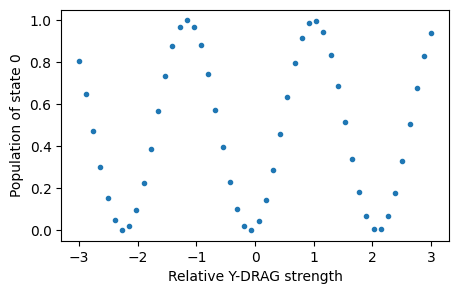

In [18]:
fig, ax = plt.subplots(figsize=(5, 3))
ax.plot(np.linspace(-3., 3., 50), data, ".")
ax.set_xlabel("Relative Y-DRAG strength")
ax.set_ylabel("Population of state 0")

Ideally, for perfect X gates, after the calibration circuit the quantum state should state in state 0. Indeed, we see that the population peaks when the raltive Y-DRAG ratio is about 1, consistent with the analytical solution we used before.

